# Exploration statistique des données combinées de l'ADEME et de Mission Transition
Ici on veut visualiser les liens entre les variables des aides et les attributs des entreprises. L'idée est de vérifier si il existe de tels lien ou non en vue de choisir un modèle qui donnera un score de compatibilité entre une offre d'aide et une entreprise.

In [1]:
import pandas as pd
import seaborn as sns
import scipy

df_ademe_mt = pd.read_csv("../data/ademe_mt_75.csv")
df_ademe_mt.columns

Index(['index_ademe', 'Nom de l attribuant_ademe', 'idAttribuant_ademe',
       'dateConvention_ademe', 'referenceDecision_ademe',
       'nomBeneficiaire_ademe', 'idBeneficiaire_ademe', 'objet_ademe',
       'montant_ademe', 'nature_ademe', 'conditionsVersement_ademe',
       'datesPeriodeVersement_ademe', 'idRAE_ademe', 'notificationUE_ademe',
       'pourcentageSubvention_ademe', 'location.lat_ademe',
       'location.lon_ademe', 'DEPET_ademe', 'naf1etlib_ademe',
       'naf2etlib_ademe', 'naf3etlib_ademe', 'naf4etlib_ademe',
       'naf5etlib_ademe', 'id_mt', 'name_mt', 'perimeter_mt', 'goal_mt',
       'beneficiary_mt', 'aidDetails_mt', 'eligibility_mt', 'conditions_mt',
       'fundingSourceUrl_mt', 'applicationEndDate_mt', 'applicationUrl_mt',
       'slug_mt', 'environmentalTopics_mt', 'fundingTypes_mt', 'regions_mt',
       'contactGuidelines_mt', 'subventionRateUpperBound_mt',
       'subventionRateLowerBound_mt', 'loanAmount_mt',
       'applicationStartDate_mt', 'projectExa

In [18]:
# Let's choose columns that seems usefull for our prediction
columns = ['nomBeneficiaire_ademe', 'montant_ademe', 'pourcentageSubvention_ademe', 'naf1etlib_ademe',
       'naf2etlib_ademe', 'naf3etlib_ademe', 'naf4etlib_ademe',
       'naf5etlib_ademe','id_mt',  'environmentalTopics_mt', 'fundingTypes_mt']

df = df_ademe_mt[columns]
df.head()

,nomBeneficiaire_ademe,montant_ademe,pourcentageSubvention_ademe,naf1etlib_ademe,naf2etlib_ademe,naf3etlib_ademe,naf4etlib_ademe,naf5etlib_ademe,id_mt,environmentalTopics_mt,fundingTypes_mt
0,CLEMENT SAS,6500.0,1.0,Industrie manufacturière,Fabrication de machines et équipements n.c.a.,Fabrication de machines de formage des métaux ...,Fabrication de machines de formage des métaux,Fabrication de machines-outils pour le travail...,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière']
1,INDUSTRIE DOLOISE DE MICRO-MECANIQUE,12150.0,1.0,Industrie manufacturière,"Fabrication de produits métalliques, à l'excep...",Traitement et revêtement des métaux ; usinage,Usinage,Mécanique industrielle,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière']
2,TRANSDEV BFC SUD,16000.0,1.0,Transports et entreposage,Transports terrestres et transport par conduites,Autres transports terrestres de voyageurs,Autres transports terrestres de voyageurs n.c.a.,Transports routiers réguliers de voyageurs,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière']
3,LOCA TRAVAUX EURL,16400.0,1.0,Activités de services administratifs et de sou...,Activités de location et location-bail,"Location et location-bail d'autres machines, é...",Location et location-bail de machines et équip...,Location et location-bail de machines et équip...,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière']
4,RODESCHINI SAS,21500.0,1.0,Construction,Travaux de construction spécialisés,Autres travaux de construction spécialisés,Autres travaux de construction spécialisés n.c.a.,Travaux de maçonnerie générale et gros œuvre d...,44,[{'name': 'Achat & location véhicules peu poll...,['Autre aide financière']


In [21]:
df.describe()

,montant_ademe,pourcentageSubvention_ademe,id_mt
count,4.740000e+02,474.000000,474.000000
mean,6.647250e+04,0.995021,186.375527
std,4.881025e+05,0.058863,122.340228
min,3.401400e+02,0.050000,38.000000
25%,5.000000e+03,1.000000,44.000000
50%,8.001000e+03,1.000000,266.000000
75%,2.066900e+04,1.000000,269.000000
max,1.012710e+07,1.000000,395.000000


In [7]:
df["fundingTypes_mt"].value_counts()

['Subvention']                             298
['Autre aide financière']                  169
['Subvention', 'Autre aide financière']      4
['Subvention', 'Ingénierie technique']       2
['Ingénierie technique']                     1
Name: fundingTypes_mt, dtype: int64

## Lien entre les secteurs d'activités et les variables de Mission Transition.
On cherche à étudier les liens entres des paires de variables, l'une associée à l'entreprise et l'autre associé aux aides. Pour l'instant la donnée principale du côté de l'entreprise est le secteur d'activité, donné ici par les différents niveaux du code NAF. Du côté des aides, on a les thématiques de Mission Transition et les types d'aides. Plus tard, on pourra enrichir les données et ajouter de nouvelles variables, notament côté entreprise grâce à l'API Sirene.

On explore le tableau de contingence entre le secteur d'activité donné par le premier code NAF et la thématique proposé empiriquement par l'equipe de Mission transition.

In [9]:
contingency_table = pd.crosstab(df['naf1etlib_ademe'], df['environmentalTopics_mt'], margins=True)
contingency_table

environmentalTopics_mt,"[{'name': ""Réduction de l'empreinte carbone"", 'id': 3}]","[{'name': ""Réduction de la consommation d'énergie"", 'id': 6}, {'name': 'Bilan énergétique & Rénovation', 'id': 7}]","[{'name': 'Achat & location véhicules peu polluants', 'id': 23}, {'name': 'Bilan énergétique & Rénovation', 'id': 7}, {'name': 'Energies Renouvelables', 'id': 22}, {'name': 'Tri, recyclage, réemploi & réparation', 'id': 15}, {'name': 'Traitement & valorisation des biodéchets', 'id': 17}, {'name': 'Réduction du gaspillage', 'id': 9}, {'name': 'Réduction des pollutions & dépollution', 'id': 8}, {'name': ""Réduction de l'empreinte carbone"", 'id': 3}, {'name': 'Sensibilisation & Formation', 'id': 37}]","[{'name': 'Aide au recrutement', 'id': 49}]","[{'name': 'Démarche écoconception', 'id': 5}, {'name': ""Performance environnementale de l'alimentation"", 'id': 26}]","[{'name': 'Démarche écoconception', 'id': 5}]","[{'name': 'Développement de filières recyclage', 'id': 31}]","[{'name': 'Energies Renouvelables', 'id': 22}, {'name': 'Réseaux de chaleur & Récupération de chaleur', 'id': 12}]","[{'name': 'Energies Renouvelables', 'id': 22}]","[{'name': 'Réduction du gaspillage', 'id': 9}]","[{'name': 'Réseaux de chaleur & Récupération de chaleur', 'id': 12}]","[{'name': 'Traitement & valorisation des biodéchets', 'id': 17}]","[{'name': 'Tri, recyclage, réemploi & réparation', 'id': 15}]",All
naf1etlib_ademe,,,,,,,,,,,,,,
Activités de services administratifs et de soutien,0,0,10,0,0,0,0,0,1,0,0,0,0,11
Activités financières et d'assurance,0,0,3,0,0,0,0,0,3,0,0,0,0,6
Activités immobilières,0,0,3,0,0,0,1,2,23,0,0,0,0,29
"Activités spécialisées, scientifiques et techniques",0,0,19,0,1,0,0,1,7,1,1,0,0,30
Administration publique,4,0,0,0,0,0,2,32,39,2,9,1,1,90
"Agriculture, sylviculture et pêche",0,0,1,0,0,0,1,2,9,0,1,0,0,14
"Arts, spectacles et activités récréatives",0,0,3,0,0,0,0,0,3,0,0,0,0,6
Autres activités de services,3,2,2,1,0,0,0,2,6,3,0,0,0,19
Commerce ; réparation d'automobiles et de motocycles,0,0,41,0,0,1,0,1,1,0,0,0,2,46


Ici on voit dans le tableau de contingence de fort écart entre les données. On ne peut malheureusement pas appliquer un test du chi-2 car le tableau ne satisfait pas la condition que chaque entré est supérieure à 5. Cependant on peut tout de même comparer a la main le tableu des contingences ci-dessus avec le tableau des valeurs attendues si on suppose une indépendance des deux variables.

In [10]:
expected = scipy.stats.contingency.expected_freq(contingency_table)
df_expected = pd.DataFrame(data = expected, index = contingency_table.index, columns = contingency_table.columns)
df_expected

environmentalTopics_mt,"[{'name': ""Réduction de l'empreinte carbone"", 'id': 3}]","[{'name': ""Réduction de la consommation d'énergie"", 'id': 6}, {'name': 'Bilan énergétique & Rénovation', 'id': 7}]","[{'name': 'Achat & location véhicules peu polluants', 'id': 23}, {'name': 'Bilan énergétique & Rénovation', 'id': 7}, {'name': 'Energies Renouvelables', 'id': 22}, {'name': 'Tri, recyclage, réemploi & réparation', 'id': 15}, {'name': 'Traitement & valorisation des biodéchets', 'id': 17}, {'name': 'Réduction du gaspillage', 'id': 9}, {'name': 'Réduction des pollutions & dépollution', 'id': 8}, {'name': ""Réduction de l'empreinte carbone"", 'id': 3}, {'name': 'Sensibilisation & Formation', 'id': 37}]","[{'name': 'Aide au recrutement', 'id': 49}]","[{'name': 'Démarche écoconception', 'id': 5}, {'name': ""Performance environnementale de l'alimentation"", 'id': 26}]","[{'name': 'Démarche écoconception', 'id': 5}]","[{'name': 'Développement de filières recyclage', 'id': 31}]","[{'name': 'Energies Renouvelables', 'id': 22}, {'name': 'Réseaux de chaleur & Récupération de chaleur', 'id': 12}]","[{'name': 'Energies Renouvelables', 'id': 22}]","[{'name': 'Réduction du gaspillage', 'id': 9}]","[{'name': 'Réseaux de chaleur & Récupération de chaleur', 'id': 12}]","[{'name': 'Traitement & valorisation des biodéchets', 'id': 17}]","[{'name': 'Tri, recyclage, réemploi & réparation', 'id': 15}]",All
naf1etlib_ademe,,,,,,,,,,,,,,
Activités de services administratifs et de soutien,0.186837,0.140127,3.900212,0.023355,0.023355,0.046709,0.186837,1.377919,3.316348,0.186837,1.401274,0.023355,0.186837,11.0
Activités financières et d'assurance,0.101911,0.076433,2.127389,0.012739,0.012739,0.025478,0.101911,0.751592,1.808917,0.101911,0.764331,0.012739,0.101911,6.0
Activités immobilières,0.492569,0.369427,10.282378,0.061571,0.061571,0.123142,0.492569,3.632696,8.743100,0.492569,3.694268,0.061571,0.492569,29.0
"Activités spécialisées, scientifiques et techniques",0.509554,0.382166,10.636943,0.063694,0.063694,0.127389,0.509554,3.757962,9.044586,0.509554,3.821656,0.063694,0.509554,30.0
Administration publique,1.528662,1.146497,31.910828,0.191083,0.191083,0.382166,1.528662,11.273885,27.133758,1.528662,11.464968,0.191083,1.528662,90.0
"Agriculture, sylviculture et pêche",0.237792,0.178344,4.963907,0.029724,0.029724,0.059448,0.237792,1.753715,4.220807,0.237792,1.783439,0.029724,0.237792,14.0
"Arts, spectacles et activités récréatives",0.101911,0.076433,2.127389,0.012739,0.012739,0.025478,0.101911,0.751592,1.808917,0.101911,0.764331,0.012739,0.101911,6.0
Autres activités de services,0.322718,0.242038,6.736730,0.040340,0.040340,0.080679,0.322718,2.380042,5.728238,0.322718,2.420382,0.040340,0.322718,19.0
Commerce ; réparation d'automobiles et de motocycles,0.781316,0.585987,16.309979,0.097665,0.097665,0.195329,0.781316,5.762208,13.868365,0.781316,5.859873,0.097665,0.781316,46.0


Les grandes différences entre les deux tableaux pour certaines données suggèrent une relation forte entre les deux variables.

In [11]:
df.columns

Index(['dateConvention_ademe', 'nomBeneficiaire_ademe', 'montant_ademe',
       'pourcentageSubvention_ademe', 'DEPET_ademe', 'naf1etlib_ademe',
       'naf2etlib_ademe', 'naf3etlib_ademe', 'naf4etlib_ademe',
       'naf5etlib_ademe', 'id_mt', 'environmentalTopics_mt', 'fundingTypes_mt',
       'subventionRateUpperBound_mt', 'subventionRateLowerBound_mt',
       'applicationStartDate_mt'],
      dtype='object')

In [30]:
def displayRepartitionsPerValue(df, var_1, var_2):
    """This function show for every value of the variable var_1 of df the repartition of
    values of the variable var_2 of df.
            
            Parameter
            ---------
            df : A Pandas DataFrame
                A Pandas DataFrame with two columns named var_1 and var_2.
            
            var_1 : A String
                The variable to display repartition of var_2 for every value of it. 
                
            var_2 : A string
                The variable to display the repartition for every value of var_1.  
    """

    var_1_values = list(set(df[var_1].values))

    for v in var_1_values:
        df_1 = df[df[var_1] == v]
        sns.catplot(x=var_2, kind="count", palette="ch:.25", data=df_1)
        print("\n")

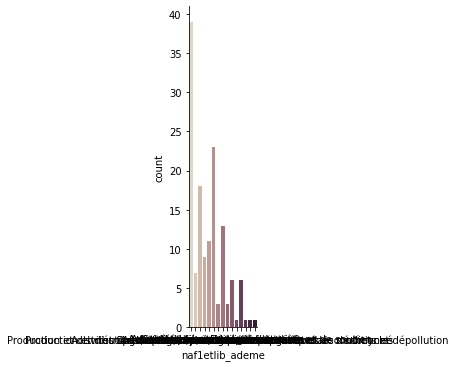

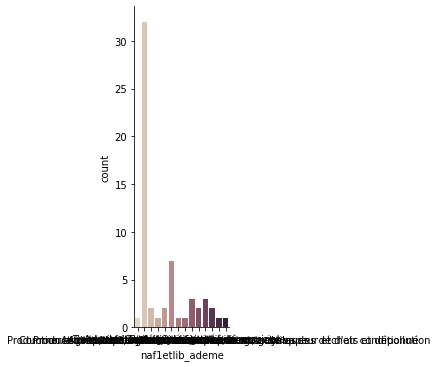

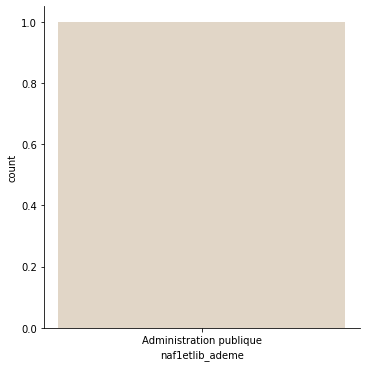

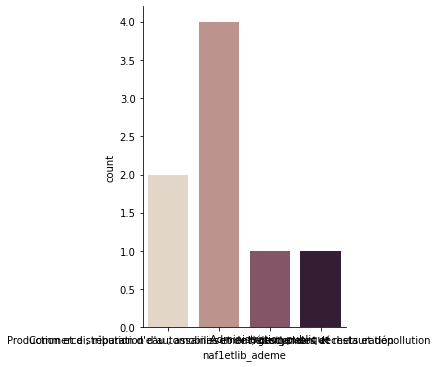

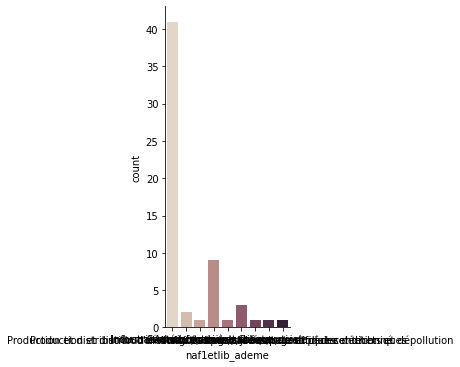

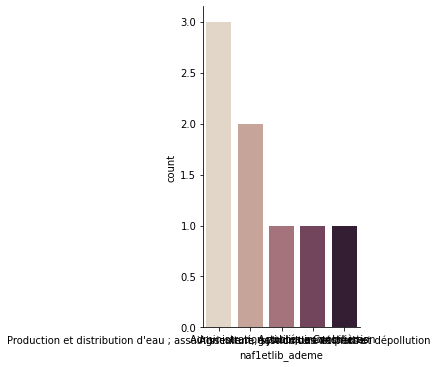

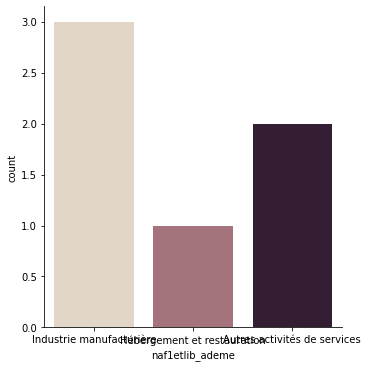

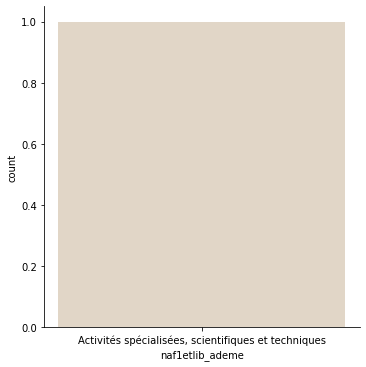

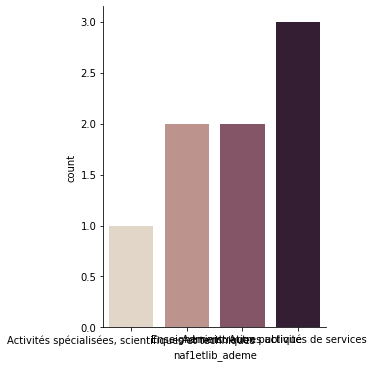

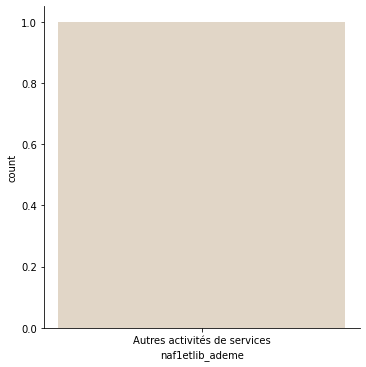

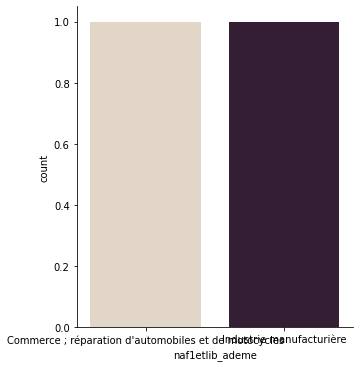

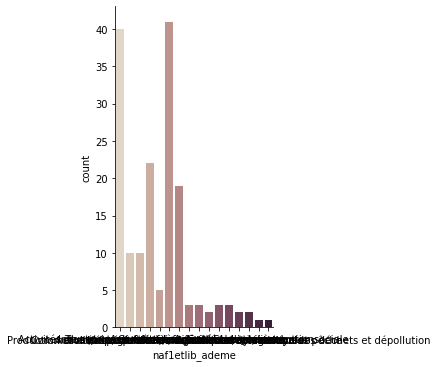

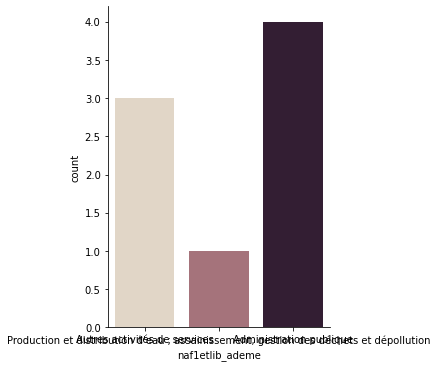

In [28]:
displayRepartitionsPerValue(df, "environmentalTopics_mt", "naf1etlib_ademe")

In [14]:
contingency_table = pd.crosstab(df['naf1etlib_ademe'], df['fundingTypes_mt'], margins=True)
contingency_table

fundingTypes_mt,['Autre aide financière'],['Ingénierie technique'],"['Subvention', 'Autre aide financière']","['Subvention', 'Ingénierie technique']",['Subvention'],All
naf1etlib_ademe,,,,,,
Activités de services administratifs et de soutien,10,0,0,0,1,11
Activités financières et d'assurance,3,0,0,0,3,6
Activités immobilières,3,0,0,0,26,29
"Activités spécialisées, scientifiques et techniques",19,0,0,1,10,30
Administration publique,1,0,1,0,88,90
"Agriculture, sylviculture et pêche",1,0,0,1,12,14
"Arts, spectacles et activités récréatives",3,0,0,0,3,6
Autres activités de services,2,0,0,0,17,19
Commerce ; réparation d'automobiles et de motocycles,41,1,2,0,2,46


In [15]:
expected = scipy.stats.contingency.expected_freq(contingency_table)
df_expected = pd.DataFrame(data = expected, index = contingency_table.index, columns = contingency_table.columns)
df_expected

fundingTypes_mt,['Autre aide financière'],['Ingénierie technique'],"['Subvention', 'Autre aide financière']","['Subvention', 'Ingénierie technique']",['Subvention'],All
naf1etlib_ademe,,,,,,
Activités de services administratifs et de soutien,3.946921,0.023355,0.093418,0.046709,6.889597,11.0
Activités financières et d'assurance,2.152866,0.012739,0.050955,0.025478,3.757962,6.0
Activités immobilières,10.405520,0.061571,0.246285,0.123142,18.163482,29.0
"Activités spécialisées, scientifiques et techniques",10.764331,0.063694,0.254777,0.127389,18.789809,30.0
Administration publique,32.292994,0.191083,0.764331,0.382166,56.369427,90.0
"Agriculture, sylviculture et pêche",5.023355,0.029724,0.118896,0.059448,8.768577,14.0
"Arts, spectacles et activités récréatives",2.152866,0.012739,0.050955,0.025478,3.757962,6.0
Autres activités de services,6.817410,0.040340,0.161359,0.080679,11.900212,19.0
Commerce ; réparation d'automobiles et de motocycles,16.505308,0.097665,0.390658,0.195329,28.811040,46.0


Ici encore on constate de grands écarts entre certaines valeurs du tableau de contingence et les valeurs attendue si on suppose indépendance des variables. Un exemple est qu'il existe qu'un seule couple ("Administration publique", "Autre aide financière") mais on en attend environ 32 ! 

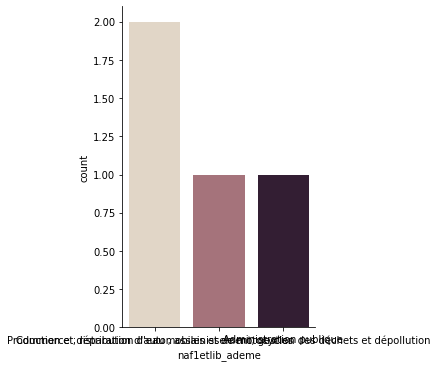

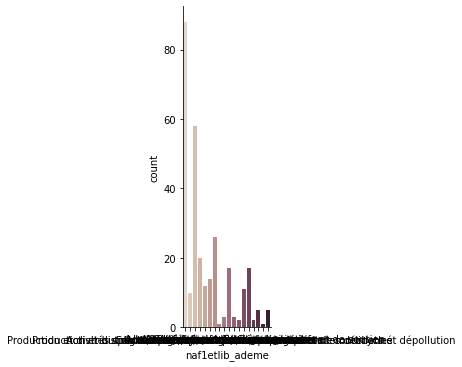

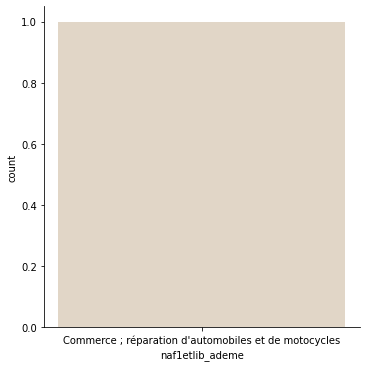

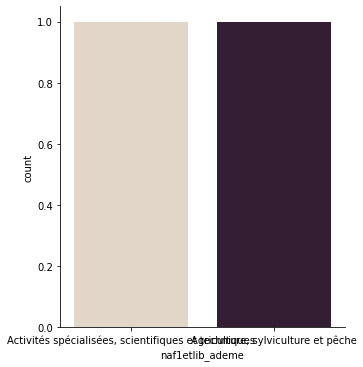

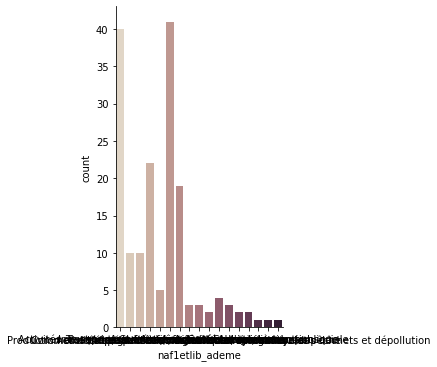

In [29]:
displayRepartitionsPerValue(df, "fundingTypes_mt", "naf1etlib_ademe")